In [2]:
import os
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import save_image

from wgan_gp import *
from utils import *

torch.manual_seed(0)

n_epochs = 200
z_dim = 512 # Latent noise vector dimension
display_step = 50
batch_size = 8
lr = 0.0001 # Learning rate
beta_1 = 0.5 # Adam b1
beta_2 = 0.999 # Adam b2
c_lambda = 10 # Gradient penalty coefficient to enforce the Lipschitz constraint

crit_repeats = 3 # Nr of times the critic will be trained for each generator training iteration

device = "cuda" if torch.cuda.is_available() else "cpu"

'''
Data transformation and loader
'''
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

# Path to dataset
data_dir = "C:/InternshipProject/Levels/dcgan_data"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator = Generator(z_dim=z_dim, im_chan=3, hidden_dim=64).to(device)
critic    = Critic(im_chan=3, hidden_dim=64).to(device)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
crit_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta_1, beta_2))

generator.apply(weights_init)
critic.apply(weights_init)

'''
Computation of the Gradient Penalty to encourage the critic's gradient norms to be close to 1, satisfying the 1-Lipschitz contraint
'''
def gradient_of_critic_score(critic, real, fake, epsilon):
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    interpolated_images.requires_grad_(True)
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

'''
Computation of the gradient penalty
'''
def gradient_penalty_l2_norm(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty

'''
Training
'''
current_step = 0
generator_losses = []
critic_losses = []

# Lists to hold the rolling-average values and the iteration index
rolling_avg_gen = []
rolling_avg_crit = []
rolling_steps = []

os.makedirs("generated_images", exist_ok=True)

def plot_images_from_tensor(tensor, num_images=16, title="Generated Images"):
    tensor = tensor.detach().cpu()  # Move to CPU if necessary
    grid = torchvision.utils.make_grid(tensor[:num_images], nrow=4, normalize=True, scale_each=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))  
    plt.axis("off")
    plt.title(title)

# Denormalizer for plotting with real colours
def denormalize(tensor):
    return tensor * 0.5 + 0.5

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
        cur_batch_size = len(real)
        real = real.to(device)

        '''Train Critic'''

        mean_crit_loss = 0
        for _ in range(crit_repeats):
            crit_optimizer.zero_grad()
            noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = generator(noise)

            crit_fake_pred = critic(fake.detach())
            crit_real_pred = critic(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            grad = gradient_of_critic_score(critic, real, fake.detach(), epsilon)
            gp = gradient_penalty_l2_norm(grad)

            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
            mean_crit_loss += crit_loss.item() / crit_repeats

            crit_loss.backward(retain_graph=True)
            crit_optimizer.step()

        critic_losses.append(mean_crit_loss)

        '''Train Generator'''

        gen_optimizer.zero_grad()
        noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = generator(noise)
        crit_fake_pred = critic(fake)
        gen_loss = get_gen_loss(crit_fake_pred)

        gen_loss.backward()
        gen_optimizer.step()
        generator_losses.append(gen_loss.item())

        '''Logging'''

        if current_step % display_step == 0 and current_step > 0:
            # Compute the rolling average of the last 'display_step' steps
            avg_gen = sum(generator_losses[-display_step:]) / display_step
            avg_crit = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {current_step}: Gen loss: {avg_gen:.4f}, Crit loss: {avg_crit:.4f}")

            # Append to the rolling lists (for plotting later)
            rolling_avg_gen.append(avg_gen)
            rolling_avg_crit.append(avg_crit)
            rolling_steps.append(current_step)

            # Generate and plot a new batch of fake images
            with torch.no_grad():
                fake_images = generator(get_noise(cur_batch_size, z_dim, device=device))

            # Denormalize to [0, 1] for visualization
            fake_images = (fake_images * 0.5) + 0.5  # Assuming normalization was [-1, 1]

            # Convert the tensor to a grid for plotting
            grid = torchvision.utils.make_grid(fake_images[:16], nrow=4, normalize=False)

            # Plot and save the image with the title
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert from CHW to HWC and move to CPU
            plt.axis("off")
            plt.title(f"Synthetic Images - G: {avg_gen:.4f}, C: {avg_crit:.4f}")
            
            # Choose location to save generated images to
            plt.savefig(f"generated_images/step_{current_step}.png", bbox_inches='tight')
            plt.close()

            

        current_step += 1



Epoch 1/200:  40%|███▉      | 51/128 [00:22<00:38,  2.00it/s]

Step 50: Gen loss: 0.1698, Crit loss: -0.0691


Epoch 1/200:  79%|███████▉  | 101/128 [00:44<00:12,  2.09it/s]

Step 100: Gen loss: 1.0491, Crit loss: -1.9495


Epoch 2/200:  18%|█▊        | 23/128 [00:10<00:51,  2.02it/s] 

Step 150: Gen loss: 1.3797, Crit loss: -3.2016


Epoch 2/200:  56%|█████▋    | 72/128 [00:32<00:24,  2.29it/s]

Step 200: Gen loss: 2.6054, Crit loss: -6.6433


Epoch 2/200:  95%|█████████▌| 122/128 [00:54<00:02,  2.24it/s]

Step 250: Gen loss: 8.6918, Crit loss: -13.6001


Epoch 3/200:  34%|███▍      | 44/128 [00:19<00:36,  2.30it/s] 

Step 300: Gen loss: 13.6412, Crit loss: -9.5570


Epoch 3/200:  73%|███████▎  | 94/128 [00:42<00:14,  2.30it/s]

Step 350: Gen loss: 26.6884, Crit loss: -41.3052


Epoch 4/200:  12%|█▎        | 16/128 [00:07<00:49,  2.27it/s] 

Step 400: Gen loss: 41.7730, Crit loss: -18.7636


Epoch 4/200:  52%|█████▏    | 66/128 [00:29<00:27,  2.29it/s]

Step 450: Gen loss: 41.8853, Crit loss: -2.9816


Epoch 4/200:  91%|█████████ | 116/128 [00:51<00:05,  2.30it/s]

Step 500: Gen loss: 51.1014, Crit loss: -45.7917


Epoch 5/200:  30%|██▉       | 38/128 [00:16<00:39,  2.26it/s] 

Step 550: Gen loss: 78.9032, Crit loss: -109.3039


Epoch 5/200:  69%|██████▉   | 88/128 [00:39<00:17,  2.28it/s]

Step 600: Gen loss: 125.6449, Crit loss: -180.2433


Epoch 6/200:   8%|▊         | 10/128 [00:04<00:52,  2.25it/s] 

Step 650: Gen loss: 148.7850, Crit loss: -5.2525


Epoch 6/200:  47%|████▋     | 60/128 [00:26<00:29,  2.31it/s]

Step 700: Gen loss: 147.9350, Crit loss: -0.2414


Epoch 6/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.29it/s]

Step 750: Gen loss: 150.5455, Crit loss: -1.9220


Epoch 7/200:  25%|██▌       | 32/128 [00:13<00:41,  2.31it/s] 

Step 800: Gen loss: 154.1445, Crit loss: -0.8905


Epoch 7/200:  65%|██████▍   | 83/128 [00:36<00:22,  2.02it/s]

Step 850: Gen loss: 154.5180, Crit loss: -0.1964


Epoch 8/200:   3%|▎         | 4/128 [00:01<00:54,  2.28it/s]  

Step 900: Gen loss: 155.4714, Crit loss: -0.5293


Epoch 8/200:  42%|████▏     | 54/128 [00:23<00:32,  2.29it/s]

Step 950: Gen loss: 155.2967, Crit loss: -1.5601


Epoch 8/200:  81%|████████▏ | 104/128 [00:46<00:10,  2.30it/s]

Step 1000: Gen loss: 153.1833, Crit loss: -10.0554


Epoch 9/200:  20%|██        | 26/128 [00:11<00:44,  2.30it/s] 

Step 1050: Gen loss: 152.1826, Crit loss: -0.5189


Epoch 9/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.27it/s]

Step 1100: Gen loss: 157.2176, Crit loss: -73.3723


Epoch 9/200:  98%|█████████▊| 126/128 [00:55<00:00,  2.30it/s]

Step 1150: Gen loss: 210.7232, Crit loss: -248.2938


Epoch 10/200:  38%|███▊      | 48/128 [00:21<00:35,  2.23it/s]

Step 1200: Gen loss: 254.9988, Crit loss: -189.3101


Epoch 10/200:  77%|███████▋  | 98/128 [00:43<00:13,  2.27it/s]

Step 1250: Gen loss: 298.2847, Crit loss: -386.3324


Epoch 11/200:  16%|█▌        | 20/128 [00:08<00:46,  2.31it/s] 

Step 1300: Gen loss: 367.3991, Crit loss: -500.2105


Epoch 11/200:  55%|█████▍    | 70/128 [00:30<00:25,  2.31it/s]

Step 1350: Gen loss: 449.0846, Crit loss: -621.7227


Epoch 11/200:  94%|█████████▍| 120/128 [00:52<00:03,  2.30it/s]

Step 1400: Gen loss: 538.0587, Crit loss: -616.2525


Epoch 12/200:  33%|███▎      | 42/128 [00:18<00:37,  2.29it/s] 

Step 1450: Gen loss: 555.9587, Crit loss: -0.0288


Epoch 12/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.31it/s]

Step 1500: Gen loss: 554.8156, Crit loss: -0.5001


Epoch 13/200:  11%|█         | 14/128 [00:06<00:49,  2.30it/s] 

Step 1550: Gen loss: 554.4975, Crit loss: -0.6173


Epoch 13/200:  50%|█████     | 64/128 [00:28<00:28,  2.27it/s]

Step 1600: Gen loss: 554.7939, Crit loss: -0.3388


Epoch 13/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.31it/s]

Step 1650: Gen loss: 555.6025, Crit loss: -0.4997


Epoch 14/200:  28%|██▊       | 36/128 [00:15<00:39,  2.30it/s] 

Step 1700: Gen loss: 556.0222, Crit loss: -0.7868


Epoch 14/200:  67%|██████▋   | 86/128 [00:37<00:18,  2.27it/s]

Step 1750: Gen loss: 555.8511, Crit loss: -0.8419


Epoch 15/200:   6%|▋         | 8/128 [00:03<00:52,  2.28it/s]  

Step 1800: Gen loss: 556.4736, Crit loss: -1.2369


Epoch 15/200:  45%|████▌     | 58/128 [00:26<00:30,  2.26it/s]

Step 1850: Gen loss: 557.1590, Crit loss: 0.5503


Epoch 15/200:  84%|████████▍ | 108/128 [00:48<00:08,  2.27it/s]

Step 1900: Gen loss: 555.8634, Crit loss: -0.1277


Epoch 16/200:  23%|██▎       | 30/128 [00:13<00:42,  2.32it/s] 

Step 1950: Gen loss: 555.5552, Crit loss: -0.2130


Epoch 16/200:  62%|██████▎   | 80/128 [00:35<00:20,  2.30it/s]

Step 2000: Gen loss: 556.0904, Crit loss: -0.2238


Epoch 17/200:   2%|▏         | 2/128 [00:00<00:55,  2.28it/s]  

Step 2050: Gen loss: 556.5723, Crit loss: -0.5286


Epoch 17/200:  41%|████      | 52/128 [00:22<00:32,  2.31it/s]

Step 2100: Gen loss: 556.7658, Crit loss: -0.6679


Epoch 17/200:  80%|███████▉  | 102/128 [00:45<00:11,  2.28it/s]

Step 2150: Gen loss: 556.6122, Crit loss: -1.1321


Epoch 18/200:  19%|█▉        | 24/128 [00:10<00:45,  2.30it/s] 

Step 2200: Gen loss: 557.1707, Crit loss: -1.1592


Epoch 18/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.28it/s]

Step 2250: Gen loss: 555.4177, Crit loss: 0.8442


Epoch 18/200:  97%|█████████▋| 124/128 [00:54<00:01,  2.30it/s]

Step 2300: Gen loss: 554.1268, Crit loss: -0.5841


Epoch 19/200:  36%|███▌      | 46/128 [00:20<00:35,  2.30it/s] 

Step 2350: Gen loss: 555.2393, Crit loss: -1.2911


Epoch 19/200:  75%|███████▌  | 96/128 [00:42<00:14,  2.28it/s]

Step 2400: Gen loss: 557.9012, Crit loss: -3.3822


Epoch 20/200:  14%|█▍        | 18/128 [00:07<00:47,  2.30it/s] 

Step 2450: Gen loss: 562.7844, Crit loss: -8.3764


Epoch 20/200:  53%|█████▎    | 68/128 [00:30<00:26,  2.30it/s]

Step 2500: Gen loss: 558.0843, Crit loss: 7.6307


Epoch 20/200:  92%|█████████▏| 118/128 [00:52<00:04,  2.30it/s]

Step 2550: Gen loss: 558.8383, Crit loss: -10.4034


Epoch 21/200:  31%|███▏      | 40/128 [00:17<00:38,  2.31it/s] 

Step 2600: Gen loss: 558.6336, Crit loss: -13.4113


Epoch 21/200:  71%|███████   | 91/128 [00:40<00:18,  2.01it/s]

Step 2650: Gen loss: 558.8337, Crit loss: -32.7515


Epoch 22/200:   9%|▉         | 12/128 [00:05<00:50,  2.30it/s] 

Step 2700: Gen loss: 556.4193, Crit loss: -6.2387


Epoch 22/200:  48%|████▊     | 62/128 [00:27<00:28,  2.31it/s]

Step 2750: Gen loss: 547.6502, Crit loss: -0.9884


Epoch 22/200:  88%|████████▊ | 112/128 [00:49<00:06,  2.31it/s]

Step 2800: Gen loss: 548.3084, Crit loss: -0.5348


Epoch 23/200:  27%|██▋       | 34/128 [00:14<00:41,  2.27it/s] 

Step 2850: Gen loss: 548.7416, Crit loss: -0.7224


Epoch 23/200:  66%|██████▌   | 84/128 [00:36<00:19,  2.31it/s]

Step 2900: Gen loss: 548.7432, Crit loss: -0.9394


Epoch 24/200:   5%|▍         | 6/128 [00:02<00:54,  2.22it/s]  

Step 2950: Gen loss: 548.7501, Crit loss: -1.1378


Epoch 24/200:  44%|████▍     | 56/128 [00:24<00:31,  2.27it/s]

Step 3000: Gen loss: 548.6766, Crit loss: -1.2728


Epoch 24/200:  83%|████████▎ | 106/128 [00:47<00:09,  2.29it/s]

Step 3050: Gen loss: 548.4047, Crit loss: -1.3806


Epoch 25/200:  22%|██▏       | 28/128 [00:12<00:43,  2.31it/s] 

Step 3100: Gen loss: 548.1730, Crit loss: -2.1600


Epoch 25/200:  61%|██████    | 78/128 [00:34<00:21,  2.31it/s]

Step 3150: Gen loss: 547.4637, Crit loss: -3.2576


Epoch 26/200:   0%|          | 0/128 [00:00<?, ?it/s]          

Step 3200: Gen loss: 546.2914, Crit loss: -6.1354


Epoch 26/200:  39%|███▉      | 50/128 [00:22<00:33,  2.31it/s]

Step 3250: Gen loss: 543.4066, Crit loss: -1.5053


Epoch 26/200:  78%|███████▊  | 100/128 [00:44<00:12,  2.26it/s]

Step 3300: Gen loss: 542.6598, Crit loss: -8.5941


Epoch 27/200:  17%|█▋        | 22/128 [00:09<00:46,  2.29it/s] 

Step 3350: Gen loss: 538.1164, Crit loss: -7.7752


Epoch 27/200:  56%|█████▋    | 72/128 [00:31<00:24,  2.29it/s]

Step 3400: Gen loss: 535.6794, Crit loss: -7.8687


Epoch 27/200:  95%|█████████▌| 122/128 [00:53<00:02,  2.31it/s]

Step 3450: Gen loss: 534.0665, Crit loss: -16.4489


Epoch 28/200:  34%|███▍      | 44/128 [00:19<00:36,  2.31it/s] 

Step 3500: Gen loss: 533.6820, Crit loss: -16.9437


Epoch 28/200:  73%|███████▎  | 94/128 [00:41<00:15,  2.23it/s]

Step 3550: Gen loss: 525.5572, Crit loss: -19.0741


Epoch 29/200:  12%|█▎        | 16/128 [00:06<00:48,  2.32it/s] 

Step 3600: Gen loss: 526.6778, Crit loss: -19.3860


Epoch 29/200:  52%|█████▏    | 66/128 [00:28<00:26,  2.30it/s]

Step 3650: Gen loss: 536.5379, Crit loss: -35.7436


Epoch 29/200:  91%|█████████ | 116/128 [00:50<00:05,  2.31it/s]

Step 3700: Gen loss: 545.5762, Crit loss: -89.2353


Epoch 30/200:  30%|██▉       | 38/128 [00:16<00:39,  2.25it/s] 

Step 3750: Gen loss: 561.0440, Crit loss: -120.5484


Epoch 30/200:  69%|██████▉   | 88/128 [00:38<00:18,  2.14it/s]

Step 3800: Gen loss: 558.0586, Crit loss: -105.5607


Epoch 31/200:   8%|▊         | 10/128 [00:04<00:51,  2.30it/s] 

Step 3850: Gen loss: 543.6842, Crit loss: 1.0385


Epoch 31/200:  47%|████▋     | 60/128 [00:26<00:29,  2.29it/s]

Step 3900: Gen loss: 536.7860, Crit loss: -0.7686


Epoch 31/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.31it/s]

Step 3950: Gen loss: 537.4485, Crit loss: -1.0405


Epoch 32/200:  25%|██▌       | 32/128 [00:13<00:41,  2.30it/s] 

Step 4000: Gen loss: 536.4382, Crit loss: -1.9358


Epoch 32/200:  64%|██████▍   | 82/128 [00:35<00:19,  2.31it/s]

Step 4050: Gen loss: 536.1696, Crit loss: -1.4184


Epoch 33/200:   3%|▎         | 4/128 [00:01<00:53,  2.30it/s]  

Step 4100: Gen loss: 536.1763, Crit loss: -2.2384


Epoch 33/200:  42%|████▏     | 54/128 [00:23<00:32,  2.28it/s]

Step 4150: Gen loss: 533.6976, Crit loss: -1.6072


Epoch 33/200:  81%|████████▏ | 104/128 [00:46<00:10,  2.29it/s]

Step 4200: Gen loss: 532.5177, Crit loss: -4.6117


Epoch 34/200:  20%|██        | 26/128 [00:11<00:44,  2.31it/s] 

Step 4250: Gen loss: 536.6434, Crit loss: -6.7639


Epoch 34/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.32it/s]

Step 4300: Gen loss: 535.1321, Crit loss: -20.7956


Epoch 34/200:  98%|█████████▊| 126/128 [00:55<00:00,  2.30it/s]

Step 4350: Gen loss: 533.2597, Crit loss: -13.6443


Epoch 35/200:  38%|███▊      | 48/128 [00:20<00:35,  2.25it/s] 

Step 4400: Gen loss: 554.4025, Crit loss: -0.8309


Epoch 35/200:  77%|███████▋  | 98/128 [00:43<00:13,  2.28it/s]

Step 4450: Gen loss: 543.5340, Crit loss: -56.1019


Epoch 36/200:  16%|█▌        | 20/128 [00:08<00:47,  2.29it/s] 

Step 4500: Gen loss: 557.6348, Crit loss: -101.3256


Epoch 36/200:  55%|█████▌    | 71/128 [00:31<00:28,  2.03it/s]

Step 4550: Gen loss: 570.6756, Crit loss: -159.3519


Epoch 36/200:  94%|█████████▍| 120/128 [00:52<00:03,  2.30it/s]

Step 4600: Gen loss: 609.1634, Crit loss: -320.0891


Epoch 37/200:  33%|███▎      | 42/128 [00:18<00:37,  2.31it/s] 

Step 4650: Gen loss: 633.4017, Crit loss: -414.7549


Epoch 37/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.32it/s]

Step 4700: Gen loss: 653.8296, Crit loss: -266.9452


Epoch 38/200:  12%|█▏        | 15/128 [00:06<00:55,  2.02it/s] 

Step 4750: Gen loss: 631.6170, Crit loss: 5.2063


Epoch 38/200:  50%|█████     | 64/128 [00:28<00:27,  2.32it/s]

Step 4800: Gen loss: 631.2002, Crit loss: 0.7283


Epoch 38/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.31it/s]

Step 4850: Gen loss: 631.3706, Crit loss: -0.9054


Epoch 39/200:  28%|██▊       | 36/128 [00:15<00:39,  2.31it/s] 

Step 4900: Gen loss: 631.9620, Crit loss: 0.0295


Epoch 39/200:  67%|██████▋   | 86/128 [00:37<00:18,  2.29it/s]

Step 4950: Gen loss: 631.8175, Crit loss: -1.1440


Epoch 40/200:   6%|▋         | 8/128 [00:03<00:51,  2.31it/s]  

Step 5000: Gen loss: 631.7903, Crit loss: -1.5139


Epoch 40/200:  46%|████▌     | 59/128 [00:26<00:34,  2.03it/s]

Step 5050: Gen loss: 632.2351, Crit loss: -0.4508


Epoch 40/200:  84%|████████▍ | 108/128 [00:47<00:08,  2.27it/s]

Step 5100: Gen loss: 633.1301, Crit loss: -0.9347


Epoch 41/200:  23%|██▎       | 30/128 [00:13<00:44,  2.21it/s] 

Step 5150: Gen loss: 633.6867, Crit loss: -0.9932


Epoch 41/200:  62%|██████▎   | 80/128 [00:35<00:20,  2.31it/s]

Step 5200: Gen loss: 632.6120, Crit loss: 2.1345


Epoch 42/200:   2%|▏         | 2/128 [00:00<00:54,  2.30it/s]  

Step 5250: Gen loss: 633.5970, Crit loss: -0.5383


Epoch 42/200:  41%|████      | 52/128 [00:23<00:32,  2.31it/s]

Step 5300: Gen loss: 633.7483, Crit loss: -0.7571


Epoch 42/200:  80%|███████▉  | 102/128 [00:45<00:11,  2.30it/s]

Step 5350: Gen loss: 634.1483, Crit loss: -1.0738


Epoch 43/200:  19%|█▉        | 24/128 [00:10<00:45,  2.31it/s] 

Step 5400: Gen loss: 634.4389, Crit loss: -1.6045


Epoch 43/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.30it/s]

Step 5450: Gen loss: 634.7061, Crit loss: -1.8432


Epoch 43/200:  97%|█████████▋| 124/128 [00:54<00:01,  2.29it/s]

Step 5500: Gen loss: 634.8932, Crit loss: -3.6445


Epoch 44/200:  36%|███▌      | 46/128 [00:19<00:35,  2.31it/s] 

Step 5550: Gen loss: 631.1532, Crit loss: 2.9955


Epoch 44/200:  76%|███████▌  | 97/128 [00:42<00:15,  2.00it/s]

Step 5600: Gen loss: 626.6020, Crit loss: -0.4457


Epoch 45/200:  14%|█▍        | 18/128 [00:07<00:47,  2.32it/s] 

Step 5650: Gen loss: 629.5740, Crit loss: -0.7747


Epoch 45/200:  53%|█████▎    | 68/128 [00:29<00:26,  2.30it/s]

Step 5700: Gen loss: 631.1493, Crit loss: -0.8749


Epoch 45/200:  92%|█████████▏| 118/128 [00:51<00:04,  2.30it/s]

Step 5750: Gen loss: 632.2936, Crit loss: -0.9594


Epoch 46/200:  31%|███▏      | 40/128 [00:17<00:38,  2.30it/s] 

Step 5800: Gen loss: 632.9101, Crit loss: -1.1372


Epoch 46/200:  70%|███████   | 90/128 [00:39<00:16,  2.28it/s]

Step 5850: Gen loss: 633.6679, Crit loss: -1.6736


Epoch 47/200:   9%|▉         | 12/128 [00:05<00:51,  2.25it/s] 

Step 5900: Gen loss: 634.2424, Crit loss: -2.6438


Epoch 47/200:  48%|████▊     | 62/128 [00:27<00:28,  2.32it/s]

Step 5950: Gen loss: 632.5487, Crit loss: -0.0373


Epoch 47/200:  88%|████████▊ | 112/128 [00:49<00:06,  2.30it/s]

Step 6000: Gen loss: 632.1659, Crit loss: -1.0197


Epoch 48/200:  27%|██▋       | 34/128 [00:14<00:40,  2.31it/s] 

Step 6050: Gen loss: 632.6101, Crit loss: -1.6575


Epoch 48/200:  66%|██████▌   | 84/128 [00:36<00:19,  2.28it/s]

Step 6100: Gen loss: 632.9150, Crit loss: -2.5974


Epoch 49/200:   5%|▍         | 6/128 [00:02<00:53,  2.30it/s]  

Step 6150: Gen loss: 632.8040, Crit loss: -3.8927


Epoch 49/200:  44%|████▍     | 56/128 [00:24<00:31,  2.30it/s]

Step 6200: Gen loss: 630.2589, Crit loss: -15.1446


Epoch 49/200:  84%|████████▎ | 107/128 [00:47<00:10,  1.95it/s]

Step 6250: Gen loss: 605.9824, Crit loss: -46.0662


Epoch 50/200:  22%|██▏       | 28/128 [00:12<00:43,  2.32it/s] 

Step 6300: Gen loss: 604.5545, Crit loss: 5.3583


Epoch 50/200:  61%|██████    | 78/128 [00:34<00:21,  2.29it/s]

Step 6350: Gen loss: 588.9421, Crit loss: -82.9292


Epoch 51/200:   1%|          | 1/128 [00:00<01:20,  1.57it/s]  

Step 6400: Gen loss: 619.7357, Crit loss: -267.7878


Epoch 51/200:  39%|███▉      | 50/128 [00:22<00:33,  2.32it/s]

Step 6450: Gen loss: 652.8237, Crit loss: 149.4812


Epoch 51/200:  78%|███████▊  | 100/128 [00:44<00:12,  2.30it/s]

Step 6500: Gen loss: 622.6994, Crit loss: 12.4969


Epoch 52/200:  17%|█▋        | 22/128 [00:09<00:45,  2.31it/s] 

Step 6550: Gen loss: 622.5930, Crit loss: 0.6748


Epoch 52/200:  56%|█████▋    | 72/128 [00:31<00:24,  2.31it/s]

Step 6600: Gen loss: 622.3562, Crit loss: 0.1632


Epoch 52/200:  95%|█████████▌| 122/128 [00:53<00:02,  2.27it/s]

Step 6650: Gen loss: 622.0847, Crit loss: -0.1148


Epoch 53/200:  34%|███▍      | 44/128 [00:19<00:36,  2.30it/s] 

Step 6700: Gen loss: 621.6662, Crit loss: -0.3436


Epoch 53/200:  73%|███████▎  | 94/128 [00:41<00:14,  2.29it/s]

Step 6750: Gen loss: 620.9041, Crit loss: -0.8123


Epoch 54/200:  12%|█▎        | 16/128 [00:06<00:48,  2.31it/s] 

Step 6800: Gen loss: 622.3096, Crit loss: -3.7397


Epoch 54/200:  52%|█████▏    | 67/128 [00:29<00:30,  2.02it/s]

Step 6850: Gen loss: 623.9150, Crit loss: -5.9715


Epoch 54/200:  91%|█████████ | 116/128 [00:50<00:05,  2.29it/s]

Step 6900: Gen loss: 627.5167, Crit loss: -8.6540


Epoch 55/200:  30%|██▉       | 38/128 [00:16<00:39,  2.30it/s] 

Step 6950: Gen loss: 628.4972, Crit loss: 1.1704


Epoch 55/200:  69%|██████▉   | 88/128 [00:38<00:17,  2.28it/s]

Step 7000: Gen loss: 630.5143, Crit loss: -7.3807


Epoch 56/200:   8%|▊         | 10/128 [00:04<00:51,  2.28it/s] 

Step 7050: Gen loss: 633.4096, Crit loss: -10.6867


Epoch 56/200:  47%|████▋     | 60/128 [00:26<00:29,  2.28it/s]

Step 7100: Gen loss: 636.6385, Crit loss: -18.5443


Epoch 56/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.30it/s]

Step 7150: Gen loss: 630.0993, Crit loss: -48.9506


Epoch 57/200:  25%|██▌       | 32/128 [00:13<00:41,  2.29it/s] 

Step 7200: Gen loss: 633.2556, Crit loss: -71.5886


Epoch 57/200:  64%|██████▍   | 82/128 [00:35<00:19,  2.31it/s]

Step 7250: Gen loss: 657.0274, Crit loss: -322.2054


Epoch 58/200:   3%|▎         | 4/128 [00:01<00:54,  2.26it/s]  

Step 7300: Gen loss: 717.3036, Crit loss: -490.1864


Epoch 58/200:  42%|████▏     | 54/128 [00:23<00:32,  2.30it/s]

Step 7350: Gen loss: 798.2342, Crit loss: -723.2441


Epoch 58/200:  81%|████████▏ | 104/128 [00:45<00:10,  2.28it/s]

Step 7400: Gen loss: 817.8122, Crit loss: -792.8486


Epoch 59/200:  20%|██        | 26/128 [00:11<00:44,  2.31it/s] 

Step 7450: Gen loss: 560.6167, Crit loss: -412.5916


Epoch 59/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.33it/s]

Step 7500: Gen loss: 714.1209, Crit loss: -666.6566


Epoch 59/200:  99%|█████████▉| 127/128 [00:55<00:00,  2.02it/s]

Step 7550: Gen loss: 815.5103, Crit loss: -784.5136


Epoch 60/200:  38%|███▊      | 49/128 [00:21<00:39,  2.02it/s] 

Step 7600: Gen loss: 900.0635, Crit loss: -1194.0595


Epoch 60/200:  77%|███████▋  | 99/128 [00:43<00:14,  2.03it/s]

Step 7650: Gen loss: 960.3106, Crit loss: -1525.7161


Epoch 61/200:  16%|█▌        | 20/128 [00:08<00:47,  2.29it/s] 

Step 7700: Gen loss: 1061.1212, Crit loss: -1665.6343


Epoch 61/200:  55%|█████▍    | 70/128 [00:30<00:25,  2.28it/s]

Step 7750: Gen loss: 1109.9409, Crit loss: -1678.6599


Epoch 61/200:  94%|█████████▍| 120/128 [00:53<00:03,  2.30it/s]

Step 7800: Gen loss: 1108.4883, Crit loss: -1496.3827


Epoch 62/200:  33%|███▎      | 42/128 [00:18<00:37,  2.27it/s] 

Step 7850: Gen loss: 1195.7010, Crit loss: -1889.0330


Epoch 62/200:  72%|███████▏  | 92/128 [00:40<00:16,  2.24it/s]

Step 7900: Gen loss: 1250.5952, Crit loss: -66.1215


Epoch 63/200:  11%|█         | 14/128 [00:06<00:49,  2.32it/s] 

Step 7950: Gen loss: 1186.5703, Crit loss: 7.3166


Epoch 63/200:  51%|█████     | 65/128 [00:28<00:31,  2.02it/s]

Step 8000: Gen loss: 1182.2826, Crit loss: 3.3734


Epoch 63/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.26it/s]

Step 8050: Gen loss: 1181.1559, Crit loss: 1.6531


Epoch 64/200:  28%|██▊       | 36/128 [00:15<00:39,  2.31it/s] 

Step 8100: Gen loss: 1180.9415, Crit loss: 1.2596


Epoch 64/200:  67%|██████▋   | 86/128 [00:37<00:18,  2.30it/s]

Step 8150: Gen loss: 1180.8037, Crit loss: 1.3789


Epoch 65/200:   6%|▋         | 8/128 [00:03<00:52,  2.29it/s]  

Step 8200: Gen loss: 1180.4499, Crit loss: 0.2647


Epoch 65/200:  45%|████▌     | 58/128 [00:25<00:30,  2.30it/s]

Step 8250: Gen loss: 1180.3651, Crit loss: 0.4859


Epoch 65/200:  84%|████████▍ | 108/128 [00:47<00:08,  2.28it/s]

Step 8300: Gen loss: 1180.2712, Crit loss: -0.0065


Epoch 66/200:  23%|██▎       | 30/128 [00:13<00:42,  2.30it/s] 

Step 8350: Gen loss: 1180.7024, Crit loss: 0.0164


Epoch 66/200:  62%|██████▎   | 80/128 [00:35<00:21,  2.27it/s]

Step 8400: Gen loss: 1180.9496, Crit loss: 0.2255


Epoch 67/200:   2%|▏         | 2/128 [00:00<00:54,  2.32it/s]  

Step 8450: Gen loss: 1180.9152, Crit loss: -0.0451


Epoch 67/200:  41%|████      | 52/128 [00:23<00:33,  2.25it/s]

Step 8500: Gen loss: 1180.9938, Crit loss: 0.2398


Epoch 67/200:  80%|███████▉  | 102/128 [00:45<00:11,  2.29it/s]

Step 8550: Gen loss: 1180.9064, Crit loss: -0.7664


Epoch 68/200:  19%|█▉        | 24/128 [00:10<00:45,  2.29it/s] 

Step 8600: Gen loss: 1180.7393, Crit loss: -1.4121


Epoch 68/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.29it/s]

Step 8650: Gen loss: 1180.0372, Crit loss: 2.1891


Epoch 68/200:  97%|█████████▋| 124/128 [00:55<00:01,  2.28it/s]

Step 8700: Gen loss: 1178.2825, Crit loss: 2.2564


Epoch 69/200:  36%|███▌      | 46/128 [00:20<00:35,  2.30it/s] 

Step 8750: Gen loss: 1176.9470, Crit loss: 1.5090


Epoch 69/200:  75%|███████▌  | 96/128 [00:42<00:13,  2.32it/s]

Step 8800: Gen loss: 1175.7970, Crit loss: 0.4766


Epoch 70/200:  14%|█▍        | 18/128 [00:07<00:51,  2.14it/s] 

Step 8850: Gen loss: 1175.3997, Crit loss: 0.6886


Epoch 70/200:  53%|█████▎    | 68/128 [00:30<00:26,  2.30it/s]

Step 8900: Gen loss: 1174.8390, Crit loss: 0.4738


Epoch 70/200:  92%|█████████▏| 118/128 [00:52<00:04,  2.23it/s]

Step 8950: Gen loss: 1174.5755, Crit loss: 0.2337


Epoch 71/200:  31%|███▏      | 40/128 [00:17<00:38,  2.27it/s] 

Step 9000: Gen loss: 1174.3076, Crit loss: -0.0106


Epoch 71/200:  70%|███████   | 90/128 [00:39<00:16,  2.24it/s]

Step 9050: Gen loss: 1173.6993, Crit loss: -0.3208


Epoch 72/200:   9%|▉         | 12/128 [00:05<00:51,  2.25it/s] 

Step 9100: Gen loss: 1173.1530, Crit loss: -0.0710


Epoch 72/200:  48%|████▊     | 62/128 [00:27<00:29,  2.27it/s]

Step 9150: Gen loss: 1172.0440, Crit loss: -0.4845


Epoch 72/200:  88%|████████▊ | 112/128 [00:49<00:07,  2.27it/s]

Step 9200: Gen loss: 1171.7717, Crit loss: -0.4628


Epoch 73/200:  27%|██▋       | 34/128 [00:14<00:41,  2.29it/s] 

Step 9250: Gen loss: 1171.1179, Crit loss: 0.3715


Epoch 73/200:  66%|██████▌   | 84/128 [00:37<00:19,  2.26it/s]

Step 9300: Gen loss: 1169.7716, Crit loss: -0.8343


Epoch 74/200:   5%|▍         | 6/128 [00:02<00:53,  2.28it/s]  

Step 9350: Gen loss: 1169.3221, Crit loss: -1.2763


Epoch 74/200:  44%|████▍     | 56/128 [00:24<00:31,  2.29it/s]

Step 9400: Gen loss: 1168.1671, Crit loss: 0.9988


Epoch 74/200:  83%|████████▎ | 106/128 [00:46<00:09,  2.26it/s]

Step 9450: Gen loss: 1166.5410, Crit loss: -1.1428


Epoch 75/200:  22%|██▏       | 28/128 [00:12<00:43,  2.30it/s] 

Step 9500: Gen loss: 1165.3242, Crit loss: -1.0495


Epoch 75/200:  61%|██████    | 78/128 [00:34<00:21,  2.27it/s]

Step 9550: Gen loss: 1165.0758, Crit loss: -1.0452


Epoch 76/200:   0%|          | 0/128 [00:00<?, ?it/s]          

Step 9600: Gen loss: 1163.8228, Crit loss: -1.5896


Epoch 76/200:  39%|███▉      | 50/128 [00:22<00:33,  2.31it/s]

Step 9650: Gen loss: 1164.1437, Crit loss: -1.9950


Epoch 76/200:  78%|███████▊  | 100/128 [00:44<00:12,  2.30it/s]

Step 9700: Gen loss: 1161.4369, Crit loss: 8.2249


Epoch 77/200:  17%|█▋        | 22/128 [00:09<00:46,  2.29it/s] 

Step 9750: Gen loss: 1162.1768, Crit loss: -0.4472


Epoch 77/200:  56%|█████▋    | 72/128 [00:31<00:25,  2.21it/s]

Step 9800: Gen loss: 1161.3221, Crit loss: -0.8159


Epoch 77/200:  95%|█████████▌| 122/128 [00:53<00:02,  2.30it/s]

Step 9850: Gen loss: 1161.4178, Crit loss: -1.4518


Epoch 78/200:  34%|███▍      | 44/128 [00:19<00:36,  2.28it/s] 

Step 9900: Gen loss: 1161.8856, Crit loss: -1.6465


Epoch 78/200:  73%|███████▎  | 94/128 [00:41<00:15,  2.23it/s]

Step 9950: Gen loss: 1161.2196, Crit loss: -1.9133


Epoch 79/200:  12%|█▎        | 16/128 [00:07<00:49,  2.29it/s] 

Step 10000: Gen loss: 1160.8289, Crit loss: -2.0957


Epoch 79/200:  52%|█████▏    | 66/128 [00:29<00:26,  2.30it/s]

Step 10050: Gen loss: 1160.9657, Crit loss: -3.0325


Epoch 79/200:  91%|█████████ | 116/128 [00:51<00:05,  2.31it/s]

Step 10100: Gen loss: 1161.4803, Crit loss: 1.4283


Epoch 80/200:  30%|██▉       | 38/128 [00:16<00:39,  2.30it/s] 

Step 10150: Gen loss: 1162.7209, Crit loss: -3.8519


Epoch 80/200:  69%|██████▉   | 88/128 [00:38<00:17,  2.29it/s]

Step 10200: Gen loss: 1162.8938, Crit loss: -3.6100


Epoch 81/200:   8%|▊         | 10/128 [00:04<00:51,  2.29it/s] 

Step 10250: Gen loss: 1162.1903, Crit loss: -3.4553


Epoch 81/200:  47%|████▋     | 60/128 [00:26<00:30,  2.26it/s]

Step 10300: Gen loss: 1163.1235, Crit loss: -3.8246


Epoch 81/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.28it/s]

Step 10350: Gen loss: 1163.4077, Crit loss: -7.2604


Epoch 82/200:  25%|██▌       | 32/128 [00:13<00:41,  2.30it/s] 

Step 10400: Gen loss: 1163.1864, Crit loss: -10.8125


Epoch 82/200:  64%|██████▍   | 82/128 [00:35<00:20,  2.29it/s]

Step 10450: Gen loss: 1167.2961, Crit loss: -36.4339


Epoch 83/200:   3%|▎         | 4/128 [00:01<00:53,  2.31it/s]  

Step 10500: Gen loss: 1189.3488, Crit loss: -0.8222


Epoch 83/200:  42%|████▏     | 54/128 [00:23<00:32,  2.30it/s]

Step 10550: Gen loss: 1196.0675, Crit loss: -23.4036


Epoch 83/200:  81%|████████▏ | 104/128 [00:46<00:10,  2.28it/s]

Step 10600: Gen loss: 1199.1059, Crit loss: -32.6056


Epoch 84/200:  20%|██        | 26/128 [00:11<00:44,  2.31it/s] 

Step 10650: Gen loss: 1225.3889, Crit loss: 50.3430


Epoch 84/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.28it/s]

Step 10700: Gen loss: 1232.8396, Crit loss: -0.4246


Epoch 84/200:  98%|█████████▊| 126/128 [00:55<00:00,  2.28it/s]

Step 10750: Gen loss: 1232.7211, Crit loss: 2.2485


Epoch 85/200:  38%|███▊      | 48/128 [00:21<00:35,  2.27it/s] 

Step 10800: Gen loss: 1236.5971, Crit loss: -11.6140


Epoch 85/200:  77%|███████▋  | 98/128 [00:43<00:13,  2.28it/s]

Step 10850: Gen loss: 1228.6961, Crit loss: 63.4339


Epoch 86/200:  16%|█▌        | 20/128 [00:08<00:47,  2.29it/s] 

Step 10900: Gen loss: 1199.1232, Crit loss: 0.7837


Epoch 86/200:  55%|█████▍    | 70/128 [00:31<00:25,  2.30it/s]

Step 10950: Gen loss: 1200.7631, Crit loss: 0.0417


Epoch 86/200:  94%|█████████▍| 120/128 [00:53<00:03,  2.28it/s]

Step 11000: Gen loss: 1201.7367, Crit loss: 0.3285


Epoch 87/200:  33%|███▎      | 42/128 [00:18<00:37,  2.30it/s] 

Step 11050: Gen loss: 1202.9243, Crit loss: 0.5490


Epoch 87/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.30it/s]

Step 11100: Gen loss: 1204.2768, Crit loss: 1.5443


Epoch 88/200:  11%|█         | 14/128 [00:06<00:49,  2.30it/s] 

Step 11150: Gen loss: 1205.1740, Crit loss: 0.2211


Epoch 88/200:  50%|█████     | 64/128 [00:28<00:27,  2.30it/s]

Step 11200: Gen loss: 1205.6925, Crit loss: -0.1439


Epoch 88/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.30it/s]

Step 11250: Gen loss: 1205.3291, Crit loss: -0.9804


Epoch 89/200:  28%|██▊       | 36/128 [00:15<00:41,  2.21it/s] 

Step 11300: Gen loss: 1203.5846, Crit loss: -1.5355


Epoch 89/200:  67%|██████▋   | 86/128 [00:38<00:18,  2.29it/s]

Step 11350: Gen loss: 1202.0225, Crit loss: -2.6094


Epoch 90/200:   6%|▋         | 8/128 [00:03<00:52,  2.31it/s]  

Step 11400: Gen loss: 1201.4885, Crit loss: -1.7264


Epoch 90/200:  45%|████▌     | 58/128 [00:25<00:30,  2.31it/s]

Step 11450: Gen loss: 1200.6109, Crit loss: -1.2701


Epoch 90/200:  84%|████████▍ | 108/128 [00:47<00:08,  2.30it/s]

Step 11500: Gen loss: 1200.4082, Crit loss: -1.6780


Epoch 91/200:  23%|██▎       | 30/128 [00:13<00:42,  2.30it/s] 

Step 11550: Gen loss: 1199.5283, Crit loss: -2.5451


Epoch 91/200:  62%|██████▎   | 80/128 [00:35<00:20,  2.29it/s]

Step 11600: Gen loss: 1199.6042, Crit loss: -3.1447


Epoch 92/200:   2%|▏         | 2/128 [00:00<00:54,  2.31it/s]  

Step 11650: Gen loss: 1198.0270, Crit loss: -1.5502


Epoch 92/200:  41%|████      | 52/128 [00:22<00:33,  2.29it/s]

Step 11700: Gen loss: 1197.6012, Crit loss: -1.2299


Epoch 92/200:  80%|███████▉  | 102/128 [00:44<00:11,  2.28it/s]

Step 11750: Gen loss: 1195.6109, Crit loss: -1.1901


Epoch 93/200:  20%|█▉        | 25/128 [00:11<00:51,  2.00it/s] 

Step 11800: Gen loss: 1192.0221, Crit loss: -2.2222


Epoch 93/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.31it/s]

Step 11850: Gen loss: 1189.4864, Crit loss: -4.4262


Epoch 93/200:  97%|█████████▋| 124/128 [00:54<00:01,  2.29it/s]

Step 11900: Gen loss: 1186.3659, Crit loss: -3.7019


Epoch 94/200:  36%|███▌      | 46/128 [00:20<00:35,  2.29it/s] 

Step 11950: Gen loss: 1191.8243, Crit loss: -5.9073


Epoch 94/200:  75%|███████▌  | 96/128 [00:42<00:14,  2.28it/s]

Step 12000: Gen loss: 1204.2933, Crit loss: -9.3016


Epoch 95/200:  14%|█▍        | 18/128 [00:07<00:47,  2.30it/s] 

Step 12050: Gen loss: 1209.3625, Crit loss: -15.2336


Epoch 95/200:  53%|█████▎    | 68/128 [00:29<00:26,  2.29it/s]

Step 12100: Gen loss: 1197.2426, Crit loss: -32.1665


Epoch 95/200:  92%|█████████▏| 118/128 [00:52<00:04,  2.31it/s]

Step 12150: Gen loss: 1173.4840, Crit loss: 106.3562


Epoch 96/200:  32%|███▏      | 41/128 [00:18<00:45,  1.92it/s] 

Step 12200: Gen loss: 1172.3423, Crit loss: 0.1244


Epoch 96/200:  70%|███████   | 90/128 [00:39<00:16,  2.28it/s]

Step 12250: Gen loss: 1172.7475, Crit loss: -0.2374


Epoch 97/200:   9%|▉         | 12/128 [00:05<00:50,  2.28it/s] 

Step 12300: Gen loss: 1172.9975, Crit loss: -0.6709


Epoch 97/200:  48%|████▊     | 62/128 [00:27<00:28,  2.29it/s]

Step 12350: Gen loss: 1173.1099, Crit loss: -0.4826


Epoch 97/200:  88%|████████▊ | 112/128 [00:49<00:07,  2.28it/s]

Step 12400: Gen loss: 1172.9440, Crit loss: -0.5946


Epoch 98/200:  27%|██▋       | 34/128 [00:14<00:41,  2.28it/s] 

Step 12450: Gen loss: 1173.9264, Crit loss: -0.9808


Epoch 98/200:  66%|██████▌   | 84/128 [00:37<00:19,  2.31it/s]

Step 12500: Gen loss: 1174.6497, Crit loss: -1.4163


Epoch 99/200:   5%|▍         | 6/128 [00:02<00:53,  2.27it/s]  

Step 12550: Gen loss: 1174.9418, Crit loss: -1.3240


Epoch 99/200:  44%|████▍     | 56/128 [00:24<00:31,  2.30it/s]

Step 12600: Gen loss: 1173.8137, Crit loss: -0.4590


Epoch 99/200:  83%|████████▎ | 106/128 [00:46<00:09,  2.25it/s]

Step 12650: Gen loss: 1172.5079, Crit loss: -0.7412


Epoch 100/200:  22%|██▏       | 28/128 [00:12<00:43,  2.28it/s]

Step 12700: Gen loss: 1171.9636, Crit loss: -0.8525


Epoch 100/200:  61%|██████    | 78/128 [00:34<00:21,  2.29it/s]

Step 12750: Gen loss: 1172.3722, Crit loss: -0.6675


Epoch 101/200:   0%|          | 0/128 [00:00<?, ?it/s]          

Step 12800: Gen loss: 1172.8422, Crit loss: -0.8096


Epoch 101/200:  39%|███▉      | 50/128 [00:22<00:34,  2.28it/s]

Step 12850: Gen loss: 1172.3293, Crit loss: -0.9713


Epoch 101/200:  78%|███████▊  | 100/128 [00:44<00:12,  2.26it/s]

Step 12900: Gen loss: 1171.1976, Crit loss: -1.1275


Epoch 102/200:  17%|█▋        | 22/128 [00:09<00:46,  2.28it/s] 

Step 12950: Gen loss: 1167.5596, Crit loss: 0.1677


Epoch 102/200:  56%|█████▋    | 72/128 [00:31<00:26,  2.15it/s]

Step 13000: Gen loss: 1166.4942, Crit loss: -0.9889


Epoch 102/200:  95%|█████████▌| 122/128 [00:54<00:02,  2.29it/s]

Step 13050: Gen loss: 1166.7335, Crit loss: -1.0365


Epoch 103/200:  34%|███▍      | 44/128 [00:19<00:36,  2.29it/s] 

Step 13100: Gen loss: 1166.9219, Crit loss: -1.0316


Epoch 103/200:  73%|███████▎  | 94/128 [00:41<00:14,  2.27it/s]

Step 13150: Gen loss: 1165.9320, Crit loss: -0.4504


Epoch 104/200:  12%|█▎        | 16/128 [00:06<00:48,  2.29it/s] 

Step 13200: Gen loss: 1162.4221, Crit loss: -0.0891


Epoch 104/200:  52%|█████▏    | 66/128 [00:28<00:26,  2.31it/s]

Step 13250: Gen loss: 1161.0294, Crit loss: -0.0544


Epoch 104/200:  91%|█████████ | 116/128 [00:51<00:05,  2.23it/s]

Step 13300: Gen loss: 1160.0816, Crit loss: 0.0277


Epoch 105/200:  30%|██▉       | 38/128 [00:16<00:39,  2.28it/s] 

Step 13350: Gen loss: 1159.3765, Crit loss: -0.0550


Epoch 105/200:  69%|██████▉   | 88/128 [00:39<00:17,  2.30it/s]

Step 13400: Gen loss: 1158.9374, Crit loss: 0.0236


Epoch 106/200:   8%|▊         | 10/128 [00:04<00:51,  2.29it/s] 

Step 13450: Gen loss: 1157.4227, Crit loss: 0.1365


Epoch 106/200:  47%|████▋     | 60/128 [00:26<00:29,  2.28it/s]

Step 13500: Gen loss: 1156.6970, Crit loss: -0.0926


Epoch 106/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.30it/s]

Step 13550: Gen loss: 1156.5740, Crit loss: -0.1559


Epoch 107/200:  25%|██▌       | 32/128 [00:13<00:41,  2.32it/s] 

Step 13600: Gen loss: 1156.5252, Crit loss: -0.0260


Epoch 107/200:  64%|██████▍   | 82/128 [00:35<00:20,  2.30it/s]

Step 13650: Gen loss: 1154.9974, Crit loss: -0.0609


Epoch 108/200:   3%|▎         | 4/128 [00:01<00:54,  2.26it/s]  

Step 13700: Gen loss: 1154.2577, Crit loss: 0.2352


Epoch 108/200:  42%|████▏     | 54/128 [00:23<00:32,  2.29it/s]

Step 13750: Gen loss: 1151.6183, Crit loss: -0.0649


Epoch 108/200:  81%|████████▏ | 104/128 [00:45<00:10,  2.29it/s]

Step 13800: Gen loss: 1151.1965, Crit loss: -0.1790


Epoch 109/200:  20%|██        | 26/128 [00:11<00:44,  2.29it/s] 

Step 13850: Gen loss: 1149.8893, Crit loss: -0.0237


Epoch 109/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.28it/s]

Step 13900: Gen loss: 1149.5936, Crit loss: -0.1849


Epoch 109/200:  98%|█████████▊| 126/128 [00:56<00:00,  2.29it/s]

Step 13950: Gen loss: 1148.2165, Crit loss: -0.3117


Epoch 110/200:  38%|███▊      | 48/128 [00:21<00:35,  2.28it/s] 

Step 14000: Gen loss: 1147.5959, Crit loss: -0.2138


Epoch 110/200:  77%|███████▋  | 98/128 [00:43<00:13,  2.29it/s]

Step 14050: Gen loss: 1148.5243, Crit loss: -0.3544


Epoch 111/200:  16%|█▌        | 20/128 [00:08<00:47,  2.28it/s] 

Step 14100: Gen loss: 1145.1148, Crit loss: -0.1337


Epoch 111/200:  55%|█████▍    | 70/128 [00:31<00:25,  2.25it/s]

Step 14150: Gen loss: 1141.2349, Crit loss: -0.3582


Epoch 111/200:  94%|█████████▍| 120/128 [00:53<00:03,  2.28it/s]

Step 14200: Gen loss: 1140.8674, Crit loss: -0.1210


Epoch 112/200:  33%|███▎      | 42/128 [00:18<00:37,  2.29it/s] 

Step 14250: Gen loss: 1138.4710, Crit loss: -0.0862


Epoch 112/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.27it/s]

Step 14300: Gen loss: 1135.7793, Crit loss: -0.3267


Epoch 113/200:  11%|█         | 14/128 [00:06<00:49,  2.29it/s] 

Step 14350: Gen loss: 1134.4193, Crit loss: -0.5058


Epoch 113/200:  50%|█████     | 64/128 [00:28<00:27,  2.31it/s]

Step 14400: Gen loss: 1129.4711, Crit loss: 0.3964


Epoch 113/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.29it/s]

Step 14450: Gen loss: 1122.1616, Crit loss: 0.0593


Epoch 114/200:  28%|██▊       | 36/128 [00:15<00:41,  2.24it/s] 

Step 14500: Gen loss: 1119.9389, Crit loss: 0.1686


Epoch 114/200:  67%|██████▋   | 86/128 [00:38<00:18,  2.27it/s]

Step 14550: Gen loss: 1118.5425, Crit loss: 0.0682


Epoch 115/200:   6%|▋         | 8/128 [00:03<00:52,  2.28it/s]  

Step 14600: Gen loss: 1118.1688, Crit loss: 0.0331


Epoch 115/200:  45%|████▌     | 58/128 [00:25<00:30,  2.29it/s]

Step 14650: Gen loss: 1116.8361, Crit loss: 0.0172


Epoch 115/200:  84%|████████▍ | 108/128 [00:48<00:08,  2.26it/s]

Step 14700: Gen loss: 1115.0414, Crit loss: -0.0205


Epoch 116/200:  23%|██▎       | 30/128 [00:13<00:42,  2.28it/s] 

Step 14750: Gen loss: 1114.1320, Crit loss: -0.1286


Epoch 116/200:  62%|██████▎   | 80/128 [00:35<00:20,  2.30it/s]

Step 14800: Gen loss: 1114.1066, Crit loss: -0.2918


Epoch 117/200:   2%|▏         | 2/128 [00:00<00:54,  2.32it/s]  

Step 14850: Gen loss: 1115.1463, Crit loss: -0.4707


Epoch 117/200:  41%|████      | 52/128 [00:22<00:32,  2.31it/s]

Step 14900: Gen loss: 1111.4092, Crit loss: -0.2284


Epoch 117/200:  80%|███████▉  | 102/128 [00:44<00:11,  2.31it/s]

Step 14950: Gen loss: 1107.7108, Crit loss: -0.2824


Epoch 118/200:  19%|█▉        | 24/128 [00:10<00:45,  2.29it/s] 

Step 15000: Gen loss: 1104.1333, Crit loss: -0.6021


Epoch 118/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.31it/s]

Step 15050: Gen loss: 1095.6166, Crit loss: -0.3880


Epoch 118/200:  97%|█████████▋| 124/128 [00:54<00:01,  2.27it/s]

Step 15100: Gen loss: 1093.2492, Crit loss: -0.1163


Epoch 119/200:  36%|███▌      | 46/128 [00:20<00:35,  2.30it/s] 

Step 15150: Gen loss: 1090.5840, Crit loss: -0.3678


Epoch 119/200:  75%|███████▌  | 96/128 [00:42<00:14,  2.28it/s]

Step 15200: Gen loss: 1087.3118, Crit loss: -0.7270


Epoch 120/200:  14%|█▍        | 18/128 [00:07<00:48,  2.28it/s] 

Step 15250: Gen loss: 1080.3224, Crit loss: -0.7814


Epoch 120/200:  53%|█████▎    | 68/128 [00:30<00:26,  2.24it/s]

Step 15300: Gen loss: 1079.7919, Crit loss: -0.3605


Epoch 120/200:  92%|█████████▏| 118/128 [00:52<00:04,  2.23it/s]

Step 15350: Gen loss: 1075.3437, Crit loss: -0.6363


Epoch 121/200:  31%|███▏      | 40/128 [00:17<00:38,  2.30it/s] 

Step 15400: Gen loss: 1071.0904, Crit loss: -0.2649


Epoch 121/200:  70%|███████   | 90/128 [00:39<00:16,  2.31it/s]

Step 15450: Gen loss: 1069.6578, Crit loss: -0.5204


Epoch 122/200:   9%|▉         | 12/128 [00:05<00:50,  2.32it/s] 

Step 15500: Gen loss: 1065.5445, Crit loss: -0.3277


Epoch 122/200:  48%|████▊     | 62/128 [00:27<00:28,  2.29it/s]

Step 15550: Gen loss: 1063.8738, Crit loss: -0.4300


Epoch 122/200:  88%|████████▊ | 112/128 [00:49<00:06,  2.30it/s]

Step 15600: Gen loss: 1055.6893, Crit loss: -0.6826


Epoch 123/200:  27%|██▋       | 34/128 [00:14<00:40,  2.30it/s] 

Step 15650: Gen loss: 1050.5965, Crit loss: -0.3701


Epoch 123/200:  66%|██████▌   | 84/128 [00:36<00:19,  2.31it/s]

Step 15700: Gen loss: 1049.8960, Crit loss: -1.6240


Epoch 124/200:   5%|▍         | 6/128 [00:02<00:52,  2.31it/s]  

Step 15750: Gen loss: 1039.0014, Crit loss: -1.9417


Epoch 124/200:  44%|████▍     | 56/128 [00:24<00:31,  2.30it/s]

Step 15800: Gen loss: 1020.9075, Crit loss: 4.0939


Epoch 124/200:  83%|████████▎ | 106/128 [00:46<00:09,  2.31it/s]

Step 15850: Gen loss: 1017.5094, Crit loss: -1.0330


Epoch 125/200:  22%|██▏       | 28/128 [00:12<00:43,  2.31it/s] 

Step 15900: Gen loss: 1022.0963, Crit loss: -2.4666


Epoch 125/200:  61%|██████    | 78/128 [00:34<00:21,  2.31it/s]

Step 15950: Gen loss: 1021.3393, Crit loss: -0.8037


Epoch 126/200:   0%|          | 0/128 [00:00<?, ?it/s]          

Step 16000: Gen loss: 1021.0117, Crit loss: -1.3033


Epoch 126/200:  39%|███▉      | 50/128 [00:22<00:34,  2.27it/s]

Step 16050: Gen loss: 1023.2544, Crit loss: -1.4504


Epoch 126/200:  78%|███████▊  | 100/128 [00:44<00:12,  2.27it/s]

Step 16100: Gen loss: 1022.9308, Crit loss: -0.5231


Epoch 127/200:  17%|█▋        | 22/128 [00:09<00:47,  2.25it/s] 

Step 16150: Gen loss: 1020.6579, Crit loss: -0.4957


Epoch 127/200:  56%|█████▋    | 72/128 [00:31<00:24,  2.31it/s]

Step 16200: Gen loss: 1018.8521, Crit loss: -0.7302


Epoch 127/200:  95%|█████████▌| 122/128 [00:53<00:02,  2.31it/s]

Step 16250: Gen loss: 1014.3912, Crit loss: -0.4062


Epoch 128/200:  34%|███▍      | 44/128 [00:19<00:36,  2.32it/s] 

Step 16300: Gen loss: 1011.8794, Crit loss: -0.7396


Epoch 128/200:  73%|███████▎  | 94/128 [00:41<00:14,  2.30it/s]

Step 16350: Gen loss: 1014.4646, Crit loss: -1.5151


Epoch 129/200:  13%|█▎        | 17/128 [00:07<00:55,  2.01it/s] 

Step 16400: Gen loss: 1015.6591, Crit loss: -0.4436


Epoch 129/200:  52%|█████▏    | 66/128 [00:28<00:26,  2.32it/s]

Step 16450: Gen loss: 1010.4776, Crit loss: -0.6457


Epoch 129/200:  91%|█████████ | 116/128 [00:50<00:05,  2.28it/s]

Step 16500: Gen loss: 1005.7422, Crit loss: -0.5032


Epoch 130/200:  30%|██▉       | 38/128 [00:16<00:40,  2.25it/s] 

Step 16550: Gen loss: 1003.7772, Crit loss: -0.4865


Epoch 130/200:  69%|██████▉   | 88/128 [00:38<00:17,  2.29it/s]

Step 16600: Gen loss: 1002.0104, Crit loss: -0.6141


Epoch 131/200:   8%|▊         | 10/128 [00:04<00:51,  2.30it/s] 

Step 16650: Gen loss: 1003.4193, Crit loss: -0.6583


Epoch 131/200:  47%|████▋     | 60/128 [00:26<00:29,  2.30it/s]

Step 16700: Gen loss: 989.4396, Crit loss: 1.1060


Epoch 131/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.30it/s]

Step 16750: Gen loss: 975.1102, Crit loss: -0.1148


Epoch 132/200:  25%|██▌       | 32/128 [00:14<00:42,  2.28it/s] 

Step 16800: Gen loss: 974.5213, Crit loss: -0.2192


Epoch 132/200:  64%|██████▍   | 82/128 [00:36<00:20,  2.28it/s]

Step 16850: Gen loss: 974.1111, Crit loss: -0.2524


Epoch 133/200:   3%|▎         | 4/128 [00:01<00:53,  2.30it/s]  

Step 16900: Gen loss: 973.6176, Crit loss: -0.3425


Epoch 133/200:  42%|████▏     | 54/128 [00:23<00:32,  2.28it/s]

Step 16950: Gen loss: 974.7627, Crit loss: -0.5936


Epoch 133/200:  81%|████████▏ | 104/128 [00:45<00:10,  2.26it/s]

Step 17000: Gen loss: 975.6986, Crit loss: -0.5595


Epoch 134/200:  20%|██        | 26/128 [00:11<00:44,  2.28it/s] 

Step 17050: Gen loss: 976.8342, Crit loss: -0.6357


Epoch 134/200:  59%|█████▉    | 76/128 [00:33<00:23,  2.19it/s]

Step 17100: Gen loss: 977.1329, Crit loss: -0.8912


Epoch 134/200:  98%|█████████▊| 126/128 [00:55<00:00,  2.29it/s]

Step 17150: Gen loss: 977.8957, Crit loss: -0.5157


Epoch 135/200:  38%|███▊      | 48/128 [00:21<00:35,  2.28it/s] 

Step 17200: Gen loss: 976.5600, Crit loss: -0.7556


Epoch 135/200:  77%|███████▋  | 98/128 [00:43<00:13,  2.28it/s]

Step 17250: Gen loss: 974.8731, Crit loss: -0.3657


Epoch 136/200:  16%|█▌        | 20/128 [00:08<00:47,  2.28it/s] 

Step 17300: Gen loss: 972.1342, Crit loss: -0.4607


Epoch 136/200:  55%|█████▍    | 70/128 [00:30<00:25,  2.31it/s]

Step 17350: Gen loss: 973.0464, Crit loss: -0.8256


Epoch 136/200:  94%|█████████▍| 120/128 [00:52<00:03,  2.26it/s]

Step 17400: Gen loss: 974.1554, Crit loss: -1.0254


Epoch 137/200:  33%|███▎      | 42/128 [00:18<00:37,  2.27it/s] 

Step 17450: Gen loss: 974.8471, Crit loss: -1.1330


Epoch 137/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.28it/s]

Step 17500: Gen loss: 977.9351, Crit loss: 0.0600


Epoch 138/200:  11%|█         | 14/128 [00:06<00:49,  2.30it/s] 

Step 17550: Gen loss: 977.0009, Crit loss: -0.2897


Epoch 138/200:  50%|█████     | 64/128 [00:28<00:27,  2.29it/s]

Step 17600: Gen loss: 977.9245, Crit loss: -0.4229


Epoch 138/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.29it/s]

Step 17650: Gen loss: 976.0606, Crit loss: -0.4952


Epoch 139/200:  28%|██▊       | 36/128 [00:15<00:40,  2.27it/s] 

Step 17700: Gen loss: 975.6217, Crit loss: -0.7279


Epoch 139/200:  67%|██████▋   | 86/128 [00:37<00:18,  2.30it/s]

Step 17750: Gen loss: 973.5046, Crit loss: -0.7910


Epoch 140/200:   6%|▋         | 8/128 [00:03<00:52,  2.31it/s]  

Step 17800: Gen loss: 974.6520, Crit loss: -0.8347


Epoch 140/200:  45%|████▌     | 58/128 [00:25<00:30,  2.30it/s]

Step 17850: Gen loss: 974.5781, Crit loss: -0.9363


Epoch 140/200:  84%|████████▍ | 108/128 [00:47<00:08,  2.29it/s]

Step 17900: Gen loss: 972.4606, Crit loss: -0.8899


Epoch 141/200:  23%|██▎       | 30/128 [00:13<00:43,  2.27it/s] 

Step 17950: Gen loss: 968.3111, Crit loss: -0.7200


Epoch 141/200:  62%|██████▎   | 80/128 [00:35<00:20,  2.29it/s]

Step 18000: Gen loss: 968.4818, Crit loss: -1.6988


Epoch 142/200:   2%|▏         | 3/128 [00:01<01:06,  1.88it/s]  

Step 18050: Gen loss: 967.1728, Crit loss: -1.8813


Epoch 142/200:  41%|████      | 52/128 [00:23<00:33,  2.29it/s]

Step 18100: Gen loss: 957.0232, Crit loss: 2.1388


Epoch 142/200:  80%|███████▉  | 102/128 [00:45<00:11,  2.28it/s]

Step 18150: Gen loss: 952.8798, Crit loss: -0.1475


Epoch 143/200:  19%|█▉        | 24/128 [00:10<00:45,  2.27it/s] 

Step 18200: Gen loss: 952.5964, Crit loss: -0.0454


Epoch 143/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.30it/s]

Step 18250: Gen loss: 953.9212, Crit loss: -0.2340


Epoch 143/200:  97%|█████████▋| 124/128 [00:54<00:01,  2.29it/s]

Step 18300: Gen loss: 950.4109, Crit loss: -0.4269


Epoch 144/200:  36%|███▌      | 46/128 [00:20<00:35,  2.29it/s] 

Step 18350: Gen loss: 947.2252, Crit loss: -0.5572


Epoch 144/200:  75%|███████▌  | 96/128 [00:42<00:13,  2.30it/s]

Step 18400: Gen loss: 945.5635, Crit loss: -0.4005


Epoch 145/200:  14%|█▍        | 18/128 [00:07<00:47,  2.30it/s] 

Step 18450: Gen loss: 944.4152, Crit loss: -0.3760


Epoch 145/200:  53%|█████▎    | 68/128 [00:29<00:26,  2.30it/s]

Step 18500: Gen loss: 943.0161, Crit loss: -0.4044


Epoch 145/200:  92%|█████████▏| 118/128 [00:51<00:04,  2.29it/s]

Step 18550: Gen loss: 941.8298, Crit loss: -0.6562


Epoch 146/200:  31%|███▏      | 40/128 [00:17<00:38,  2.29it/s] 

Step 18600: Gen loss: 941.4152, Crit loss: -0.3387


Epoch 146/200:  70%|███████   | 90/128 [00:39<00:16,  2.28it/s]

Step 18650: Gen loss: 936.5723, Crit loss: -0.3680


Epoch 147/200:   9%|▉         | 12/128 [00:05<00:50,  2.29it/s] 

Step 18700: Gen loss: 934.0548, Crit loss: -0.5722


Epoch 147/200:  48%|████▊     | 62/128 [00:27<00:28,  2.29it/s]

Step 18750: Gen loss: 931.2495, Crit loss: -0.6584


Epoch 147/200:  88%|████████▊ | 112/128 [00:49<00:07,  2.29it/s]

Step 18800: Gen loss: 929.5145, Crit loss: -0.7790


Epoch 148/200:  27%|██▋       | 34/128 [00:14<00:41,  2.29it/s] 

Step 18850: Gen loss: 924.9848, Crit loss: -0.8606


Epoch 148/200:  66%|██████▌   | 84/128 [00:37<00:19,  2.30it/s]

Step 18900: Gen loss: 920.5175, Crit loss: -1.0005


Epoch 149/200:   5%|▍         | 6/128 [00:02<00:53,  2.30it/s]  

Step 18950: Gen loss: 929.3270, Crit loss: -0.4055


Epoch 149/200:  44%|████▍     | 56/128 [00:24<00:31,  2.28it/s]

Step 19000: Gen loss: 926.6551, Crit loss: -0.3752


Epoch 149/200:  83%|████████▎ | 106/128 [00:46<00:09,  2.29it/s]

Step 19050: Gen loss: 925.4217, Crit loss: -0.5885


Epoch 150/200:  22%|██▏       | 28/128 [00:12<00:43,  2.32it/s] 

Step 19100: Gen loss: 924.5739, Crit loss: -0.7861


Epoch 150/200:  61%|██████    | 78/128 [00:34<00:21,  2.30it/s]

Step 19150: Gen loss: 912.8918, Crit loss: -0.1892


Epoch 151/200:   0%|          | 0/128 [00:00<?, ?it/s]          

Step 19200: Gen loss: 908.7458, Crit loss: -0.6939


Epoch 151/200:  39%|███▉      | 50/128 [00:22<00:33,  2.29it/s]

Step 19250: Gen loss: 911.8930, Crit loss: -0.9957


Epoch 151/200:  78%|███████▊  | 100/128 [00:44<00:12,  2.28it/s]

Step 19300: Gen loss: 911.7905, Crit loss: -0.7044


Epoch 152/200:  17%|█▋        | 22/128 [00:09<00:46,  2.28it/s] 

Step 19350: Gen loss: 910.0584, Crit loss: -0.5943


Epoch 152/200:  56%|█████▋    | 72/128 [00:31<00:24,  2.29it/s]

Step 19400: Gen loss: 910.0853, Crit loss: -1.3295


Epoch 152/200:  95%|█████████▌| 122/128 [00:53<00:02,  2.30it/s]

Step 19450: Gen loss: 905.3372, Crit loss: -0.4724


Epoch 153/200:  34%|███▍      | 44/128 [00:19<00:36,  2.28it/s] 

Step 19500: Gen loss: 905.5321, Crit loss: -1.6302


Epoch 153/200:  73%|███████▎  | 94/128 [00:41<00:14,  2.29it/s]

Step 19550: Gen loss: 909.9716, Crit loss: -1.1905


Epoch 154/200:  12%|█▎        | 16/128 [00:07<00:49,  2.28it/s] 

Step 19600: Gen loss: 914.3170, Crit loss: -1.4136


Epoch 154/200:  52%|█████▏    | 66/128 [00:29<00:27,  2.24it/s]

Step 19650: Gen loss: 908.8432, Crit loss: -0.5935


Epoch 154/200:  91%|█████████ | 116/128 [00:51<00:05,  2.25it/s]

Step 19700: Gen loss: 906.1460, Crit loss: -1.0570


Epoch 155/200:  30%|██▉       | 38/128 [00:16<00:39,  2.30it/s] 

Step 19750: Gen loss: 907.4068, Crit loss: -1.9697


Epoch 155/200:  69%|██████▉   | 88/128 [00:38<00:17,  2.30it/s]

Step 19800: Gen loss: 910.7873, Crit loss: 0.1836


Epoch 156/200:   8%|▊         | 10/128 [00:04<00:51,  2.28it/s] 

Step 19850: Gen loss: 911.6562, Crit loss: -0.1791


Epoch 156/200:  47%|████▋     | 60/128 [00:26<00:30,  2.26it/s]

Step 19900: Gen loss: 910.9806, Crit loss: -0.3669


Epoch 156/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.31it/s]

Step 19950: Gen loss: 910.3067, Crit loss: -0.6208


Epoch 157/200:  25%|██▌       | 32/128 [00:14<00:42,  2.28it/s] 

Step 20000: Gen loss: 906.7797, Crit loss: -0.8128


Epoch 157/200:  64%|██████▍   | 82/128 [00:36<00:20,  2.29it/s]

Step 20050: Gen loss: 905.3516, Crit loss: -0.5686


Epoch 158/200:   3%|▎         | 4/128 [00:01<00:54,  2.26it/s]  

Step 20100: Gen loss: 904.2915, Crit loss: -0.7530


Epoch 158/200:  42%|████▏     | 54/128 [00:24<00:32,  2.28it/s]

Step 20150: Gen loss: 903.0773, Crit loss: -1.2132


Epoch 158/200:  81%|████████▏ | 104/128 [00:46<00:10,  2.23it/s]

Step 20200: Gen loss: 908.8175, Crit loss: -1.2167


Epoch 159/200:  20%|██        | 26/128 [00:11<00:44,  2.30it/s] 

Step 20250: Gen loss: 911.6554, Crit loss: -1.5730


Epoch 159/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.30it/s]

Step 20300: Gen loss: 916.9464, Crit loss: -1.8910


Epoch 159/200:  98%|█████████▊| 126/128 [00:55<00:00,  2.31it/s]

Step 20350: Gen loss: 916.9364, Crit loss: -1.6727


Epoch 160/200:  38%|███▊      | 48/128 [00:20<00:35,  2.28it/s] 

Step 20400: Gen loss: 907.7837, Crit loss: -0.1269


Epoch 160/200:  77%|███████▋  | 98/128 [00:42<00:13,  2.29it/s]

Step 20450: Gen loss: 907.5163, Crit loss: -0.3291


Epoch 161/200:  16%|█▌        | 20/128 [00:08<00:47,  2.27it/s] 

Step 20500: Gen loss: 905.3118, Crit loss: -0.6645


Epoch 161/200:  55%|█████▍    | 70/128 [00:31<00:26,  2.17it/s]

Step 20550: Gen loss: 908.1844, Crit loss: -0.6370


Epoch 161/200:  94%|█████████▍| 120/128 [00:53<00:03,  2.28it/s]

Step 20600: Gen loss: 906.7001, Crit loss: -0.5525


Epoch 162/200:  33%|███▎      | 42/128 [00:18<00:37,  2.29it/s] 

Step 20650: Gen loss: 906.2364, Crit loss: -0.7451


Epoch 162/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.30it/s]

Step 20700: Gen loss: 907.7716, Crit loss: -0.9548


Epoch 163/200:  11%|█         | 14/128 [00:06<00:49,  2.32it/s] 

Step 20750: Gen loss: 908.2769, Crit loss: -1.5756


Epoch 163/200:  50%|█████     | 64/128 [00:28<00:28,  2.27it/s]

Step 20800: Gen loss: 909.6902, Crit loss: -1.6856


Epoch 163/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.30it/s]

Step 20850: Gen loss: 913.1431, Crit loss: -0.2068


Epoch 164/200:  28%|██▊       | 36/128 [00:15<00:40,  2.30it/s] 

Step 20900: Gen loss: 910.3213, Crit loss: -1.3983


Epoch 164/200:  67%|██████▋   | 86/128 [00:38<00:18,  2.27it/s]

Step 20950: Gen loss: 908.0595, Crit loss: -0.6005


Epoch 165/200:   6%|▋         | 8/128 [00:03<00:52,  2.27it/s]  

Step 21000: Gen loss: 910.5004, Crit loss: -0.3088


Epoch 165/200:  45%|████▌     | 58/128 [00:25<00:30,  2.27it/s]

Step 21050: Gen loss: 910.0687, Crit loss: -0.4942


Epoch 165/200:  84%|████████▍ | 108/128 [00:48<00:08,  2.27it/s]

Step 21100: Gen loss: 911.7328, Crit loss: -0.7212


Epoch 166/200:  23%|██▎       | 30/128 [00:13<00:42,  2.29it/s] 

Step 21150: Gen loss: 908.3580, Crit loss: -0.9533


Epoch 166/200:  62%|██████▎   | 80/128 [00:35<00:20,  2.30it/s]

Step 21200: Gen loss: 908.7655, Crit loss: -1.2576


Epoch 167/200:   2%|▏         | 2/128 [00:00<00:54,  2.29it/s]  

Step 21250: Gen loss: 912.2827, Crit loss: -2.9832


Epoch 167/200:  41%|████      | 52/128 [00:23<00:33,  2.27it/s]

Step 21300: Gen loss: 886.0916, Crit loss: 0.8757


Epoch 167/200:  80%|███████▉  | 102/128 [00:45<00:11,  2.27it/s]

Step 21350: Gen loss: 884.1902, Crit loss: -0.3201


Epoch 168/200:  19%|█▉        | 24/128 [00:10<00:45,  2.28it/s] 

Step 21400: Gen loss: 882.9195, Crit loss: -0.5710


Epoch 168/200:  58%|█████▊    | 74/128 [00:32<00:23,  2.26it/s]

Step 21450: Gen loss: 884.4752, Crit loss: 1.8610


Epoch 168/200:  97%|█████████▋| 124/128 [00:54<00:01,  2.29it/s]

Step 21500: Gen loss: 873.1246, Crit loss: -0.1594


Epoch 169/200:  36%|███▌      | 46/128 [00:20<00:36,  2.27it/s] 

Step 21550: Gen loss: 872.3681, Crit loss: -0.1739


Epoch 169/200:  75%|███████▌  | 96/128 [00:42<00:13,  2.29it/s]

Step 21600: Gen loss: 870.5660, Crit loss: -0.5530


Epoch 170/200:  14%|█▍        | 18/128 [00:07<00:47,  2.31it/s] 

Step 21650: Gen loss: 866.8051, Crit loss: -0.3869


Epoch 170/200:  53%|█████▎    | 68/128 [00:30<00:25,  2.31it/s]

Step 21700: Gen loss: 868.7872, Crit loss: -0.6318


Epoch 170/200:  92%|█████████▏| 118/128 [00:52<00:04,  2.29it/s]

Step 21750: Gen loss: 873.5072, Crit loss: -0.8114


Epoch 171/200:  31%|███▏      | 40/128 [00:17<00:38,  2.30it/s] 

Step 21800: Gen loss: 874.8541, Crit loss: -1.0959


Epoch 171/200:  70%|███████   | 90/128 [00:39<00:16,  2.29it/s]

Step 21850: Gen loss: 879.5854, Crit loss: -0.7579


Epoch 172/200:   9%|▉         | 12/128 [00:05<00:50,  2.29it/s] 

Step 21900: Gen loss: 878.9256, Crit loss: -0.7704


Epoch 172/200:  48%|████▊     | 62/128 [00:27<00:28,  2.29it/s]

Step 21950: Gen loss: 885.5619, Crit loss: -2.3916


Epoch 172/200:  88%|████████▊ | 112/128 [00:49<00:06,  2.30it/s]

Step 22000: Gen loss: 887.7790, Crit loss: -6.6980


Epoch 173/200:  27%|██▋       | 34/128 [00:14<00:40,  2.31it/s] 

Step 22050: Gen loss: 898.5090, Crit loss: 2.0134


Epoch 173/200:  66%|██████▌   | 84/128 [00:36<00:19,  2.30it/s]

Step 22100: Gen loss: 900.0496, Crit loss: -0.7729


Epoch 174/200:   5%|▍         | 6/128 [00:02<00:52,  2.32it/s]  

Step 22150: Gen loss: 901.5228, Crit loss: -1.9833


Epoch 174/200:  44%|████▍     | 56/128 [00:24<00:31,  2.31it/s]

Step 22200: Gen loss: 903.5396, Crit loss: -0.4074


Epoch 174/200:  83%|████████▎ | 106/128 [00:46<00:09,  2.25it/s]

Step 22250: Gen loss: 903.6859, Crit loss: -0.6851


Epoch 175/200:  22%|██▏       | 28/128 [00:12<00:44,  2.27it/s] 

Step 22300: Gen loss: 905.5159, Crit loss: -2.6890


Epoch 175/200:  61%|██████    | 78/128 [00:34<00:21,  2.32it/s]

Step 22350: Gen loss: 910.0494, Crit loss: -3.8928


Epoch 176/200:   0%|          | 0/128 [00:00<?, ?it/s]          

Step 22400: Gen loss: 923.4617, Crit loss: -9.6863


Epoch 176/200:  39%|███▉      | 50/128 [00:21<00:33,  2.32it/s]

Step 22450: Gen loss: 943.3862, Crit loss: -7.3836


Epoch 176/200:  78%|███████▊  | 100/128 [00:43<00:12,  2.28it/s]

Step 22500: Gen loss: 984.9430, Crit loss: -61.6646


Epoch 177/200:  17%|█▋        | 22/128 [00:09<00:46,  2.26it/s] 

Step 22550: Gen loss: 1093.7757, Crit loss: 82.6394


Epoch 177/200:  56%|█████▋    | 72/128 [00:32<00:24,  2.26it/s]

Step 22600: Gen loss: 1116.1369, Crit loss: -1.0797


Epoch 177/200:  95%|█████████▌| 122/128 [00:54<00:02,  2.28it/s]

Step 22650: Gen loss: 1116.6720, Crit loss: -2.9733


Epoch 178/200:  34%|███▍      | 44/128 [00:19<00:36,  2.31it/s] 

Step 22700: Gen loss: 1116.3658, Crit loss: -6.5009


Epoch 178/200:  73%|███████▎  | 94/128 [00:41<00:14,  2.30it/s]

Step 22750: Gen loss: 1113.0905, Crit loss: -14.0472


Epoch 179/200:  12%|█▎        | 16/128 [00:07<00:49,  2.26it/s] 

Step 22800: Gen loss: 1107.5203, Crit loss: -54.9248


Epoch 179/200:  52%|█████▏    | 66/128 [00:29<00:27,  2.28it/s]

Step 22850: Gen loss: 1114.1236, Crit loss: -14.1649


Epoch 179/200:  91%|█████████ | 116/128 [00:51<00:05,  2.26it/s]

Step 22900: Gen loss: 1100.0654, Crit loss: -1.2403


Epoch 180/200:  30%|██▉       | 38/128 [00:16<00:38,  2.31it/s] 

Step 22950: Gen loss: 1095.0961, Crit loss: -1.8272


Epoch 180/200:  69%|██████▉   | 88/128 [00:38<00:17,  2.29it/s]

Step 23000: Gen loss: 1093.7472, Crit loss: -2.8341


Epoch 181/200:   9%|▊         | 11/128 [00:04<00:58,  1.99it/s] 

Step 23050: Gen loss: 1091.4479, Crit loss: -1.7928


Epoch 181/200:  47%|████▋     | 60/128 [00:26<00:29,  2.30it/s]

Step 23100: Gen loss: 1091.0458, Crit loss: -0.3187


Epoch 181/200:  86%|████████▌ | 110/128 [00:48<00:07,  2.29it/s]

Step 23150: Gen loss: 1091.4626, Crit loss: 0.0533


Epoch 182/200:  25%|██▌       | 32/128 [00:13<00:41,  2.31it/s] 

Step 23200: Gen loss: 1091.6453, Crit loss: -0.1349


Epoch 182/200:  64%|██████▍   | 82/128 [00:36<00:20,  2.29it/s]

Step 23250: Gen loss: 1091.6023, Crit loss: -0.3767


Epoch 183/200:   3%|▎         | 4/128 [00:01<00:54,  2.29it/s]  

Step 23300: Gen loss: 1091.0726, Crit loss: -0.7175


Epoch 183/200:  42%|████▏     | 54/128 [00:24<00:32,  2.28it/s]

Step 23350: Gen loss: 1089.9665, Crit loss: -0.7197


Epoch 183/200:  81%|████████▏ | 104/128 [00:46<00:10,  2.25it/s]

Step 23400: Gen loss: 1089.1683, Crit loss: -0.4990


Epoch 184/200:  20%|██        | 26/128 [00:11<00:44,  2.27it/s] 

Step 23450: Gen loss: 1089.5492, Crit loss: -0.4041


Epoch 184/200:  59%|█████▉    | 76/128 [00:33<00:22,  2.28it/s]

Step 23500: Gen loss: 1089.5763, Crit loss: -0.4269


Epoch 184/200:  98%|█████████▊| 126/128 [00:55<00:00,  2.25it/s]

Step 23550: Gen loss: 1089.1268, Crit loss: -0.5438


Epoch 185/200:  38%|███▊      | 48/128 [00:20<00:35,  2.28it/s] 

Step 23600: Gen loss: 1088.4339, Crit loss: -0.7868


Epoch 185/200:  77%|███████▋  | 98/128 [00:43<00:13,  2.31it/s]

Step 23650: Gen loss: 1087.7527, Crit loss: -0.6753


Epoch 186/200:  16%|█▌        | 20/128 [00:08<00:47,  2.28it/s] 

Step 23700: Gen loss: 1086.6670, Crit loss: -0.9453


Epoch 186/200:  55%|█████▍    | 70/128 [00:30<00:25,  2.30it/s]

Step 23750: Gen loss: 1085.6126, Crit loss: -0.8031


Epoch 186/200:  94%|█████████▍| 120/128 [00:53<00:03,  2.30it/s]

Step 23800: Gen loss: 1085.2125, Crit loss: -0.4753


Epoch 187/200:  33%|███▎      | 42/128 [00:18<00:37,  2.29it/s] 

Step 23850: Gen loss: 1087.5389, Crit loss: -0.1470


Epoch 187/200:  72%|███████▏  | 92/128 [00:40<00:15,  2.29it/s]

Step 23900: Gen loss: 1086.4244, Crit loss: -0.2959


Epoch 188/200:  11%|█         | 14/128 [00:06<00:49,  2.29it/s] 

Step 23950: Gen loss: 1086.5383, Crit loss: -0.2866


Epoch 188/200:  50%|█████     | 64/128 [00:28<00:27,  2.30it/s]

Step 24000: Gen loss: 1086.7039, Crit loss: -0.2870


Epoch 188/200:  89%|████████▉ | 114/128 [00:50<00:06,  2.30it/s]

Step 24050: Gen loss: 1086.7318, Crit loss: -0.1829


Epoch 189/200:  28%|██▊       | 36/128 [00:15<00:40,  2.28it/s] 

Step 24100: Gen loss: 1086.5850, Crit loss: -0.3127


Epoch 189/200:  67%|██████▋   | 86/128 [00:38<00:18,  2.22it/s]

Step 24150: Gen loss: 1086.9797, Crit loss: -0.3830


Epoch 190/200:   6%|▋         | 8/128 [00:03<00:52,  2.28it/s]  

Step 24200: Gen loss: 1086.8056, Crit loss: -0.5060


Epoch 190/200:  45%|████▌     | 58/128 [00:25<00:30,  2.28it/s]

Step 24250: Gen loss: 1085.8785, Crit loss: -0.6689


Epoch 190/200:  84%|████████▍ | 108/128 [00:48<00:08,  2.27it/s]

Step 24300: Gen loss: 1084.9961, Crit loss: -0.8963


Epoch 191/200:  23%|██▎       | 30/128 [00:13<00:43,  2.28it/s] 

Step 24350: Gen loss: 1082.0643, Crit loss: -1.3161


Epoch 191/200:  62%|██████▎   | 80/128 [00:35<00:21,  2.28it/s]

Step 24400: Gen loss: 1083.8680, Crit loss: -2.2479


Epoch 192/200:   2%|▏         | 2/128 [00:00<00:54,  2.33it/s]  

Step 24450: Gen loss: 1098.6782, Crit loss: 39.7752


Epoch 192/200:  41%|████      | 52/128 [00:23<00:33,  2.26it/s]

Step 24500: Gen loss: 1094.2630, Crit loss: -0.6564


Epoch 192/200:  80%|███████▉  | 102/128 [00:45<00:11,  2.29it/s]

Step 24550: Gen loss: 1090.2424, Crit loss: -0.8915


Epoch 193/200:  19%|█▉        | 24/128 [00:10<00:45,  2.27it/s] 

Step 24600: Gen loss: 1089.3789, Crit loss: -0.6381


Epoch 193/200:  58%|█████▊    | 74/128 [00:32<00:24,  2.23it/s]

Step 24650: Gen loss: 1089.7284, Crit loss: -0.2474


Epoch 193/200:  97%|█████████▋| 124/128 [00:55<00:01,  2.29it/s]

Step 24700: Gen loss: 1090.3651, Crit loss: -0.4728


Epoch 194/200:  36%|███▌      | 46/128 [00:20<00:35,  2.30it/s] 

Step 24750: Gen loss: 1092.0198, Crit loss: -0.2055


Epoch 194/200:  75%|███████▌  | 96/128 [00:42<00:13,  2.31it/s]

Step 24800: Gen loss: 1093.3634, Crit loss: -0.8276


Epoch 195/200:  14%|█▍        | 18/128 [00:07<00:48,  2.26it/s] 

Step 24850: Gen loss: 1096.0993, Crit loss: -1.4724


Epoch 195/200:  53%|█████▎    | 68/128 [00:30<00:26,  2.26it/s]

Step 24900: Gen loss: 1097.2203, Crit loss: -3.3077


Epoch 195/200:  92%|█████████▏| 118/128 [00:52<00:04,  2.30it/s]

Step 24950: Gen loss: 1083.5838, Crit loss: 34.7885


Epoch 196/200:  32%|███▏      | 41/128 [00:18<00:43,  2.00it/s] 

Step 25000: Gen loss: 1072.2457, Crit loss: 0.3047


Epoch 196/200:  70%|███████   | 90/128 [00:39<00:16,  2.28it/s]

Step 25050: Gen loss: 1067.0222, Crit loss: -0.0038


Epoch 197/200:   9%|▉         | 12/128 [00:05<00:50,  2.29it/s] 

Step 25100: Gen loss: 1064.4787, Crit loss: -0.6770


Epoch 197/200:  48%|████▊     | 62/128 [00:27<00:28,  2.28it/s]

Step 25150: Gen loss: 1063.7451, Crit loss: -1.3034


Epoch 197/200:  88%|████████▊ | 112/128 [00:49<00:06,  2.31it/s]

Step 25200: Gen loss: 1063.9127, Crit loss: -1.7080


Epoch 198/200:  27%|██▋       | 34/128 [00:14<00:40,  2.32it/s] 

Step 25250: Gen loss: 1064.0155, Crit loss: -1.1696


Epoch 198/200:  66%|██████▌   | 84/128 [00:37<00:19,  2.28it/s]

Step 25300: Gen loss: 1063.7821, Crit loss: -0.3667


Epoch 199/200:   5%|▍         | 6/128 [00:02<00:53,  2.30it/s]  

Step 25350: Gen loss: 1064.2282, Crit loss: 0.1381


Epoch 199/200:  44%|████▍     | 56/128 [00:24<00:31,  2.26it/s]

Step 25400: Gen loss: 1064.0837, Crit loss: -0.0752


Epoch 199/200:  83%|████████▎ | 106/128 [00:46<00:09,  2.28it/s]

Step 25450: Gen loss: 1064.1157, Crit loss: -0.1527


Epoch 200/200:  22%|██▏       | 28/128 [00:12<00:43,  2.28it/s] 

Step 25500: Gen loss: 1064.4957, Crit loss: -0.1716


Epoch 200/200:  61%|██████    | 78/128 [00:34<00:21,  2.28it/s]

Step 25550: Gen loss: 1064.8339, Crit loss: -0.2094


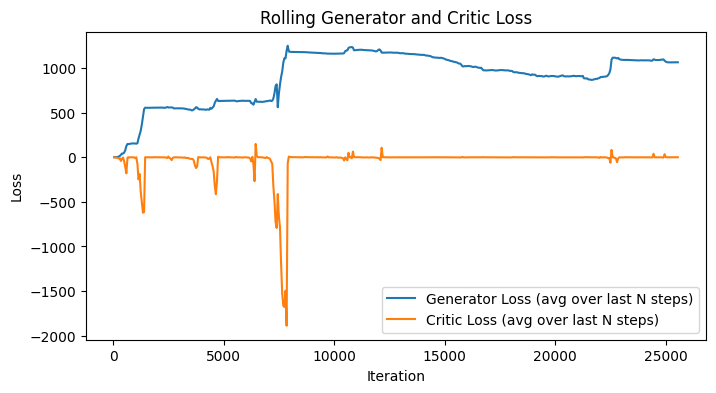

In [3]:

plt.figure(figsize=(8, 4))
plt.plot(rolling_steps, rolling_avg_gen, label="Generator Loss (avg over last N steps)")
plt.plot(rolling_steps, rolling_avg_crit, label="Critic Loss (avg over last N steps)")
plt.title("Rolling Generator and Critic Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
from torchsummary import summary
    
generator = Generator(z_dim).to(device)
summary(generator, (64, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─Sequential: 2-1                   [-1, 256, 3, 3]           --
|    |    └─ConvTranspose2d: 3-1         [-1, 256, 3, 3]           147,712
|    |    └─BatchNorm2d: 3-2             [-1, 256, 3, 3]           512
|    |    └─ReLU: 3-3                    [-1, 256, 3, 3]           --
|    └─Sequential: 2-2                   [-1, 128, 6, 6]           --
|    |    └─ConvTranspose2d: 3-4         [-1, 128, 6, 6]           524,416
|    |    └─BatchNorm2d: 3-5             [-1, 128, 6, 6]           256
|    |    └─ReLU: 3-6                    [-1, 128, 6, 6]           --
|    └─Sequential: 2-3                   [-1, 64, 13, 13]          --
|    |    └─ConvTranspose2d: 3-7         [-1, 64, 13, 13]          73,792
|    |    └─BatchNorm2d: 3-8             [-1, 64, 13, 13]          128
|    |    └─ReLU: 3-9                    [-1, 64, 13, 13]          -

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─Sequential: 2-1                   [-1, 256, 3, 3]           --
|    |    └─ConvTranspose2d: 3-1         [-1, 256, 3, 3]           147,712
|    |    └─BatchNorm2d: 3-2             [-1, 256, 3, 3]           512
|    |    └─ReLU: 3-3                    [-1, 256, 3, 3]           --
|    └─Sequential: 2-2                   [-1, 128, 6, 6]           --
|    |    └─ConvTranspose2d: 3-4         [-1, 128, 6, 6]           524,416
|    |    └─BatchNorm2d: 3-5             [-1, 128, 6, 6]           256
|    |    └─ReLU: 3-6                    [-1, 128, 6, 6]           --
|    └─Sequential: 2-3                   [-1, 64, 13, 13]          --
|    |    └─ConvTranspose2d: 3-7         [-1, 64, 13, 13]          73,792
|    |    └─BatchNorm2d: 3-8             [-1, 64, 13, 13]          128
|    |    └─ReLU: 3-9                    [-1, 64, 13, 13]          -

In [5]:
print(critic.critic[0])  

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
)
